<a href="https://colab.research.google.com/github/mveiyo/mveiyo/blob/main/deganoriginal1(Final).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/dali92002/DE-GAN.git

Cloning into 'DE-GAN'...
remote: Enumerating objects: 141, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 141 (delta 11), reused 4 (delta 4), pack-reused 124
Receiving objects: 100% (141/141), 8.90 MiB | 14.74 MiB/s, done.
Resolving deltas: 100% (55/55), done.


In [ ]:
pip install utils


  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13906 sha256=49f7bf8a23fac123cb39de27fb642e8f2106dc1b4535a172b451fb1fb30c0f5a
  Stored in directory: /root/.cache/pip/wheels/b8/39/f5/9d0ca31dba85773ececf0a7f5469f18810e1c8a8ed9da28ca7
Successfully built utils


In [ ]:
import sys
sys.path.append('/content/DE-GAN')


In [ ]:

from tensorflow import keras
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras import metrics
import scipy.misc
import os
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *


def get_optimizer():
    return Adam(lr=1e-4)

def generator_model(pretrained_weights = None,input_size = (256,256,1),biggest_layer = 512):

    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(biggest_layer//2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(biggest_layer//2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(biggest_layer, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(biggest_layer, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))

    merge6 = concatenate ([drop4,up6])
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate ([conv3,up7])

    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate ([conv2,up8])

    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))

    merge9 = concatenate ([conv1,up9])
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    return model



def discriminator_model(input_size = (256,256,1)):

    def d_layer(layer_input, filters, f_size=4, bn=True):

        d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        if bn:
            d = BatchNormalization(momentum=0.8)(d)
        return d

    img_A = Input(input_size)
    img_B = Input(input_size)

    df=64

    combined_imgs = Concatenate(axis=-1)([img_A, img_B])

    d1 = d_layer(combined_imgs, df, bn=False)
    d2 = d_layer(d1, df*2)
    d3 = d_layer(d2, df*4)
    d4 = d_layer(d3, df*4)

    validity = Conv2D(1, kernel_size=4, strides=1, padding='same', activation='sigmoid')(d4)

    discriminator = Model([img_A, img_B], validity)
    discriminator.compile(loss='mse', optimizer=get_optimizer(), metrics = ['accuracy'])

    return discriminator



def get_gan_network(discriminator, generator, input_size = (256,256,1)):
    discriminator.trainable = False

    gan_input2 = Input(input_size)

    x = generator(gan_input2)
    valid = discriminator([x,gan_input2])
    gan = Model(inputs=[gan_input2], outputs=[valid,x])
    gan.compile(loss=['mse','binary_crossentropy'],loss_weights=[1, 100], optimizer=get_optimizer(),metrics = ['accuracy'])
    return gan



In [ ]:
import numpy as np
import math




def psnr(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    if (mse == 0):
        return (100)
    PIXEL_MAX = 1.0
    return (20 * math.log10(PIXEL_MAX / math.sqrt(mse)))

def split2(dataset,size,h,w):
    newdataset=[]
    nsize1=256
    nsize2=256
    for i in range (size):
        im=dataset[i]
        for ii in range(0,h,nsize1): #2048
            for iii in range(0,w,nsize2): #1536
                newdataset.append(im[ii:ii+nsize1,iii:iii+nsize2,:])

    return np.array(newdataset)
def merge_image2(splitted_images, h,w):
    image=np.zeros(((h,w,1)))
    nsize1=256
    nsize2=256
    ind =0
    for ii in range(0,h,nsize1):
        for iii in range(0,w,nsize2):
            image[ii:ii+nsize1,iii:iii+nsize2,:]=splitted_images[ind]
            ind=ind+1
    return np.array(image)



def getPatches(watermarked_image,clean_image,mystride):
    watermarked_patches=[]
    clean_patches=[]


    h =  ((watermarked_image.shape [0] // 256) +1)*256
    w =  ((watermarked_image.shape [1] // 256 ) +1)*256
    image_padding=np.ones((h,w))
    image_padding[:watermarked_image.shape[0],:watermarked_image.shape[1]]=watermarked_image

    for j in range (0,h-256,mystride):  #128 not 64
        for k in range (0,w-256,mystride):
            watermarked_patches.append(image_padding[j:j+256,k:k+256])


    h =  ((clean_image.shape [0] // 256) +1)*256
    w =  ((clean_image.shape [1] // 256 ) +1)*256
    image_padding=np.ones((h,w))*255
    image_padding[:clean_image.shape[0],:clean_image.shape[1]]=clean_image

    for j in range (0,h-256,mystride):    #128 not 64
        for k in range (0,w-256,mystride):
            clean_patches.append(image_padding[j:j+256,k:k+256]/255)

    return np.array(watermarked_patches),np.array(clean_patches)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc
import os
from PIL import Image
from tqdm import tqdm
import random
import os.path
import imageio
from utils import *
from models.models import *


input_size = (256,256,1)



def train_gan(generator,discriminator, ep_start=1, epochs=1, batch_size=128):

    list_deg_images= os.listdir('/content/DE-GAN/data/A')
    list_clean_images= os.listdir('/content/DE-GAN/data/B')

    list_deg_images.sort()
    list_clean_images.sort()

    gan = get_gan_network(discriminator, generator)

    for e in range(ep_start, epochs+1):
        print ('\n Epoch:' ,e)

        for im in tqdm(range (len(list_deg_images))):



            deg_image_path = ('/content/DE-GAN/data/A/'+list_deg_images[im])
            deg_image = Image.open(deg_image_path)# /255.0
            deg_image = deg_image.convert('L')
            deg_image.save('curr_deg_image.png')

            deg_image = plt.imread('curr_deg_image.png')

            clean_image_path = ('/content/DE-GAN/data/B/'+list_clean_images[im])
            clean_image = Image.open(clean_image_path)# /255.0
            clean_image = clean_image.convert('L')
            clean_image.save('curr_clean_image.png')

            clean_image = plt.imread('curr_clean_image.png')#[:,:,0]


            wat_batch, gt_batch = getPatches(deg_image,clean_image,mystride=128+64)

            batch_count = wat_batch.shape[0] // batch_size




            for b in (range(batch_count)):
                seed= range(b*batch_size, (b*batch_size) + batch_size)
                b_wat_batch = wat_batch[seed].reshape(batch_size,256,256,1)
                b_gt_batch = gt_batch[seed].reshape(batch_size,256,256,1)

                generated_images = generator.predict(b_wat_batch)


                valid = np.ones((b_gt_batch.shape[0],) + (16, 16, 1))
                fake = np.zeros((b_gt_batch.shape[0],) + (16, 16, 1))

                discriminator.trainable = True
                discriminator.train_on_batch([b_gt_batch, b_wat_batch], valid)
                discriminator.train_on_batch([generated_images, b_wat_batch], fake)


                discriminator.trainable = False
                gan.train_on_batch([b_wat_batch], [valid, b_gt_batch])
        if not os.path.exists('./last_trained_weights'):
            os.makedirs('./last_trained_weights')
            discriminator.save_weights('./last_trained_weights/last_discriminator_weights.h5')
            generator.save_weights('./last_trained_weights/last_generator_weights.h5')
        # if (e == 1 or e % 2 == 0):
        #     evaluate(generator,discriminator,e)

def predic(generator, epoch):
    if not os.path.exists('Results/epoch'+str(epoch)):
        os.makedirs('Results/epoch'+str(epoch))
    for i in range(0,31):
        watermarked_image_path = ('CLEAN/VALIDATION/DATA/'+ str(i+1) + '.png')
        test_image = plt.imread(watermarked_image_path)

        h =  ((test_image.shape [0] // 256) +1)*256
        w =  ((test_image.shape [1] // 256 ) +1)*256

        test_padding=np.zeros((h,w))+1
        test_padding[:test_image.shape[0],:test_image.shape[1]]=test_image

        test_image_p=split2(test_padding.reshape(1,h,w,1),1,h,w)
        predicted_list=[]
        for l in range(test_image_p.shape[0]):
            predicted_list.append(generator.predict(test_image_p[l].reshape(1,256,256,1)))

        predicted_image = np.array(predicted_list)#.reshape()
        predicted_image=merge_image2(predicted_image,h,w)

        predicted_image=predicted_image[:test_image.shape[0],:test_image.shape[1]]
        predicted_image=predicted_image.reshape(predicted_image.shape[0],predicted_image.shape[1])
        predicted_image = (predicted_image[:,:])*255

        predicted_image =predicted_image.astype(np.uint8)
        imageio.imwrite('Results/epoch'+str(epoch)+'/predicted'+str(i+1)+'.png', predicted_image)



epo = 1

generator = generator_model(biggest_layer=1024)
discriminator = discriminator_model()




train_gan(generator,discriminator, ep_start =epo, epochs=20, batch_size=1)


 Epoch: 1


  0%|          | 0/2 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 1/2 [04:42<04:42, 282.05s/it]

1/1 [==============================] - 2s 2s/step


100%|██████████| 2/2 [10:47<00:00, 323.55s/it]



 Epoch: 2


  0%|          | 0/2 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 1/2 [04:09<04:09, 249.83s/it]

1/1 [==============================] - 3s 3s/step


100%|██████████| 2/2 [10:06<00:00, 303.37s/it]



 Epoch: 3


  0%|          | 0/2 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 1/2 [04:27<04:27, 267.03s/it]

1/1 [==============================] - 2s 2s/step


100%|██████████| 2/2 [10:29<00:00, 314.79s/it]



 Epoch: 4


  0%|          | 0/2 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 1/2 [04:20<04:20, 260.40s/it]

1/1 [==============================] - 3s 3s/step


100%|██████████| 2/2 [10:18<00:00, 309.40s/it]



 Epoch: 5


  0%|          | 0/2 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


 50%|█████     | 1/2 [04:13<04:13, 253.45s/it]

1/1 [==============================] - 2s 2s/step


100%|██████████| 2/2 [10:15<00:00, 307.94s/it]



 Epoch: 6


  0%|          | 0/2 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 1/2 [04:13<04:13, 253.48s/it]

1/1 [==============================] - 2s 2s/step


100%|██████████| 2/2 [10:10<00:00, 305.31s/it]



 Epoch: 7


  0%|          | 0/2 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 1/2 [04:12<04:12, 252.57s/it]

1/1 [==============================] - 2s 2s/step


100%|██████████| 2/2 [10:04<00:00, 302.06s/it]



 Epoch: 8


  0%|          | 0/2 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


 50%|█████     | 1/2 [04:13<04:13, 253.59s/it]

1/1 [==============================] - 2s 2s/step


100%|██████████| 2/2 [10:10<00:00, 305.17s/it]



 Epoch: 9


  0%|          | 0/2 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


 50%|█████     | 1/2 [04:07<04:07, 247.20s/it]

1/1 [==============================] - 2s 2s/step


100%|██████████| 2/2 [09:52<00:00, 296.37s/it]



 Epoch: 10


  0%|          | 0/2 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 1/2 [04:08<04:08, 248.78s/it]

1/1 [==============================] - 2s 2s/step


100%|██████████| 2/2 [09:55<00:00, 297.81s/it]



 Epoch: 11


  0%|          | 0/2 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


 50%|█████     | 1/2 [04:07<04:07, 247.86s/it]

1/1 [==============================] - 2s 2s/step


100%|██████████| 2/2 [09:54<00:00, 297.26s/it]



 Epoch: 12


  0%|          | 0/2 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 1/2 [04:07<04:07, 247.61s/it]

1/1 [==============================] - 3s 3s/step


100%|██████████| 2/2 [09:52<00:00, 296.03s/it]



 Epoch: 13


  0%|          | 0/2 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 1/2 [04:06<04:06, 246.97s/it]

1/1 [==============================] - 3s 3s/step


100%|██████████| 2/2 [09:48<00:00, 294.01s/it]



 Epoch: 14


  0%|          | 0/2 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 1/2 [04:16<04:16, 256.45s/it]

1/1 [==============================] - 2s 2s/step


100%|██████████| 2/2 [10:01<00:00, 300.89s/it]



 Epoch: 15


  0%|          | 0/2 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 1/2 [04:07<04:07, 247.79s/it]

1/1 [==============================] - 2s 2s/step


100%|██████████| 2/2 [09:54<00:00, 297.35s/it]



 Epoch: 16


  0%|          | 0/2 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 1/2 [04:10<04:10, 250.50s/it]

1/1 [==============================] - 2s 2s/step


100%|██████████| 2/2 [09:57<00:00, 298.82s/it]



 Epoch: 17


  0%|          | 0/2 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


 50%|█████     | 1/2 [04:06<04:06, 246.10s/it]

1/1 [==============================] - 2s 2s/step


100%|██████████| 2/2 [09:50<00:00, 295.42s/it]



 Epoch: 18


  0%|          | 0/2 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 1/2 [04:07<04:07, 247.79s/it]

1/1 [==============================] - 2s 2s/step


100%|██████████| 2/2 [10:12<00:00, 306.20s/it]



 Epoch: 19


  0%|          | 0/2 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 1/2 [04:15<04:15, 255.32s/it]

1/1 [==============================] - 2s 2s/step


100%|██████████| 2/2 [10:06<00:00, 303.12s/it]



 Epoch: 20


  0%|          | 0/2 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 1/2 [04:10<04:10, 250.61s/it]

1/1 [==============================] - 2s 2s/step


100%|██████████| 2/2 [10:01<00:00, 300.62s/it]


In [ ]:
deg_image_path = '/content/DE-GAN/data/A/1.bmp'
print("Deg Image Path:", deg_image_path)

clean_image_path = '/content/DE-GAN/data/B/1.bmp'
print("Clean Image Path:", clean_image_path)


Deg Image Path: /content/DE-GAN/data/A/1.bmp
Clean Image Path: /content/DE-GAN/data/B/1.bmp


In [ ]:

#!/usr/bin/env python
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc
import math
from PIL import Image


input_size = (256,256,1)

task = 'binarize'

generator = generator_model(biggest_layer=1024)
generator.load_weights('/content/drive/MyDrive/binarization_generator_weights.h5')



deg_image_path ='/content/DT1 (185).jpg'

deg_image = Image.open(deg_image_path)# /255.0
deg_image = deg_image.convert('L')
deg_image.save('curr_image.png')


test_image = plt.imread('curr_image.png')




h =  ((test_image.shape [0] // 256) +1)*256
w =  ((test_image.shape [1] // 256 ) +1)*256

test_padding=np.zeros((h,w))+1
test_padding[:test_image.shape[0],:test_image.shape[1]]=test_image

test_image_p=split2(test_padding.reshape(1,h,w,1),1,h,w)
predicted_list=[]
for l in range(test_image_p.shape[0]):
    predicted_list.append(generator.predict(test_image_p[l].reshape(1,256,256,1)))

predicted_image = np.array(predicted_list)#.reshape()
predicted_image=merge_image2(predicted_image,h,w)

predicted_image=predicted_image[:test_image.shape[0],:test_image.shape[1]]
predicted_image=predicted_image.reshape(predicted_image.shape[0],predicted_image.shape[1])





save_path = '/content/curr_image.png'







1/1 [==============================] - 2s 2s/step


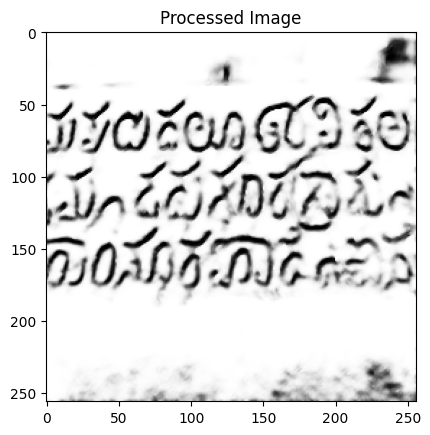

In [ ]:
# Display the processed image using matplotlib
plt.imshow(predicted_image, cmap='gray')
plt.title('Processed Image')
plt.show()






